In [11]:
import os
import time
import copy
import torch
import jax
import jax.numpy as jnp
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import datasets, models, transforms
from torchvision.models import vgg16_bn, alexnet
from torchvision.models import VGG16_BN_Weights, AlexNet_Weights
from torchvision.datasets.folder import default_loader
from torchvision.datasets.utils import download_url
from torch.utils.data import Dataset

# Dataset

In [12]:
# https://github.com/TDeVries/cub2011_dataset/blob/master/cub2011.py

class Cub2011(Dataset):
    base_folder = 'CUB_200_2011/images'
    url = 'https://data.caltech.edu/records/65de6-vp158/files/CUB_200_2011.tgz'
    filename = 'CUB_200_2011.tgz'
    tgz_md5 = '97eceeb196236b17998738112f37df78'

    def __init__(self, root, train=True, transform=None, loader=default_loader, download=True):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.loader = default_loader
        self.train = train

        if download:
            self._download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

    def _load_metadata(self):
        images = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'images.txt'), sep=' ',
                             names=['img_id', 'filepath'])
        image_class_labels = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'image_class_labels.txt'),
                                         sep=' ', names=['img_id', 'target'])
        train_test_split = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'train_test_split.txt'),
                                       sep=' ', names=['img_id', 'is_training_img'])

        data = images.merge(image_class_labels, on='img_id')
        self.data = data.merge(train_test_split, on='img_id')

        if self.train is not None:
            if self.train:
                self.data = self.data[self.data.is_training_img == 1]
            else:
                self.data = self.data[self.data.is_training_img == 0]

    def _check_integrity(self):
        try:
            self._load_metadata()
        except Exception:
            return False

        for index, row in self.data.iterrows():
            filepath = os.path.join(self.root, self.base_folder, row.filepath)
            if not os.path.isfile(filepath):
                print(filepath)
                return False
        return True

    def _download(self):
        import tarfile

        if self._check_integrity():
            print('Files already downloaded and verified')
            return

        download_url(self.url, self.root, self.filename, self.tgz_md5)

        with tarfile.open(os.path.join(self.root, self.filename), "r:gz") as tar:
            tar.extractall(path=self.root)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        path = os.path.join(self.root, self.base_folder, sample.filepath)
        target = sample.target - 1  # Targets start at 1 by default, so shift to 0
        img = self.loader(path)

        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [13]:
# load data

cub_root = 'drive/MyDrive/CUB-200'
# cub = Cub2011(cub_root)

# Model

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [15]:
# https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/finetuning_torchvision_models_tutorial.ipynb#scrollTo=P5h5t-00hst3

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history


def set_parameter_requires_grad(model, freeze):
    if freeze == 'all':
        for param in model.parameters():
            param.requires_grad = False
    elif freeze == 'conv':
        for param in model.features.parameters():
            param.requires_grad = False


def initialize_model(model_name, num_classes, freeze=None, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == "alexnet":
        model_ft = alexnet(AlexNet_Weights.IMAGENET1K_V1)
    elif model_name == "vgg":
        model_ft = vgg16_bn(VGG16_BN_Weights.IMAGENET1K_V1)
    else:
        print("Invalid model name, exiting...")
        return model_ft
    set_parameter_requires_grad(model_ft, freeze)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)

    return model_ft

In [16]:
model_name = "vgg"
num_classes = 200
batch_size = 64
num_epochs = 100
input_size = 224

In [17]:
# model_ft = initialize_model(model_name, num_classes, freeze='all', use_pretrained=True)
# model_ft.to(device)

In [18]:
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(input_size),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(input_size),
#         transforms.CenterCrop(input_size),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

In [19]:
# cub_train = Cub2011(cub_root, train=True, transform=data_transforms['train'], loader=default_loader, download=False)
# cub_test = Cub2011(cub_root, train=False, transform=data_transforms['val'], loader=default_loader, download=False)

In [20]:
# dataloaders = {
#     'train': torch.utils.data.DataLoader(cub_train, batch_size=batch_size, shuffle=True, num_workers=2),
#     'val': torch.utils.data.DataLoader(cub_test, batch_size=batch_size, shuffle=False, num_workers=2)
# }

In [21]:
# optimizer = optim.Adam(model_ft.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
# criterion = nn.CrossEntropyLoss()

# model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer, scheduler, num_epochs=num_epochs)

In [22]:
# torch.save(model_ft, 'drive/My Drive/vgg16_bn_cub200.pt')

# Experiments

## Image preview

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
model_ft = torch.load('drive/My Drive/vgg16_bn_cub200.pt', map_location=device)
model_ft.to(device)
model_ft.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [25]:
with open(os.path.join(cub_root, 'CUB_200_2011/classes.txt')) as f:
    class_names = [c.split()[1].strip() for c in f.readlines()]

In [26]:
resize = transforms.Compose([
    transforms.Resize((input_size, input_size)),
])

normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

resize2 = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
])

normalize2 = transforms.Compose([
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

WHITE = np.ones((input_size, input_size, 3)) * 255.0

def blur(image):
    return np.array(transforms.GaussianBlur((101, 101), sigma=10)(image))

def zeros(image):
    return np.zeros_like(image)

def chmean(image):
    image = np.array(image)
    image[:, :] = np.mean(image, (0, 1))
    return image

In [27]:
cub200 = Cub2011(cub_root, train=None, transform=resize, download=False)

In [28]:
# img_ids = [115] # exp0
# img_ids = [51, 94, 153, 232, 322] # exp1
# img_ids = [582, 1528, 1624, 2238] # exp3

image, label = cub200[115]

In [29]:
def show_image(image, label):
    plt.imshow(image)
    plt.title(class_names[label])
    plt.show();

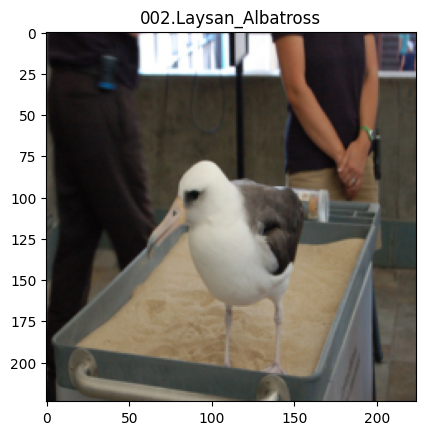

In [30]:
show_image(image, label)

## GradCAM

In [31]:
clf = nn.Sequential(model_ft.avgpool, nn.Flatten().to(device), model_ft.classifier)
clf.eval()
for _, p in clf.named_parameters():
    p.requires_grad = True

def classifier(features, target):
    logits = clf(features)[0]
    return logits.max() if target is None else logits[target], logits

def grad_cam_fn_contrast(img, contrast='weighted', target=None):
    if not torch.is_tensor(img):
        img = normalize(img)
        img = img[np.newaxis, :]
    else:
        img = normalize2(img)
    img = img.to(device)
    features = model_ft.features(img)
    features.requires_grad = True
    logit, logits = classifier(features, target)
    grad, = torch.autograd.grad(logit, features, torch.tensor(1.))
    relevance = torch.einsum('bchw,bc->bhw', features.detach(), torch.mean(grad.detach(), axis=(2, 3)))
    model_ft.zero_grad(set_to_none=True)

    if contrast == 'max':
        s = logits.argsort()[-2] if target is None or target == logits.argmax() else logits.argmax()
        logit, _ = classifier(features, s)
        grad2, = torch.autograd.grad(logit, features, torch.tensor(1.))
        relevance -= torch.einsum('bchw,bc->hw', features.detach(), torch.mean(grad2.detach(), axis=(2, 3)))
    elif contrast is not None:
        fn = lambda g: torch.einsum('bchw,c->hw', features, torch.mean(g, axis=(1, 2)))
        grads = torch.cat([torch.autograd.grad(classifier(features, c)[0], features, torch.tensor(1.))[0].detach() for c in range(num_classes)])
        relevances = torch.vmap(fn)(grads)
        if contrast == 'mean':
            relevance = num_classes * relevance - torch.sum(relevances, axis=0)
        elif contrast == 'weighted':
            relevance = torch.sum(torch.exp(logits)) * relevance - torch.einsum('kij,k->ij', relevances, torch.exp(logits))

    relevance = resize(relevance)[0]
    relevance /= relevance.abs().max()

    return logits.detach().cpu(), relevance.detach().cpu()

def linear_approx_contrast(img, contrast='weighted', target=None):
    if not torch.is_tensor(img):
        img = normalize(img)
        img = img[np.newaxis, :]
    else:
        img = normalize2(img)
    img = img.to(device)
    features = model_ft.features(img)
    features.requires_grad = True
    logit, logits = classifier(features, target)
    grad, = torch.autograd.grad(logit, features, torch.tensor(1.))
    relevance = (features.detach() * grad.detach()).sum(1)
    clf.zero_grad(set_to_none=True)
    model_ft.zero_grad(set_to_none=True)

    if contrast == 'weighted':
        grads = [(features.detach() * torch.autograd.grad(classifier(features, c)[0], features, torch.tensor(1.))[0].detach()).sum(1) for c in range(num_classes)]
        relevances = torch.cat(grads)
        relevance = torch.sum(torch.exp(logits)) * relevance - torch.einsum('kij,k->ij', relevances, torch.exp(logits))

    relevance = resize(relevance)[0]
    relevance /= relevance.abs().max()

    return logits.detach().cpu(), relevance.detach().cpu()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


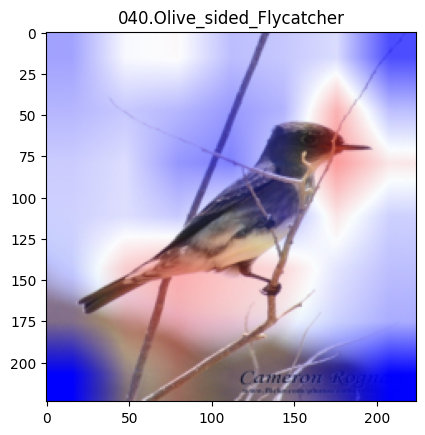

In [32]:
image, label = cub200[2238]

RED = np.zeros_like(image)
RED[:, :, 0] = 1.0
BLUE = np.zeros_like(image)
BLUE[:, :, 2] = 1.0

def blend(a, b, alpha):
    return (1 - alpha) * a + alpha * b

def explain(image, contrast, target=None, map=None, background=None, method=grad_cam_fn_contrast):
    if background is None:
        background = image
    if map:
        _, relevance = method(image, contrast=contrast, target=target)
        image = np.array(background) / 255
        if map == 'red' or map == 'both':
            image = blend(image, RED, torch.clamp(relevance, min=0).numpy()[:, :, np.newaxis])
        if map == 'blue' or map == 'both':
            image = blend(image, BLUE, -torch.clamp(relevance, max=0).numpy()[:, :, np.newaxis])
    return image

show_image(explain(image, contrast='mean', target=178, map='both', method=linear_approx_contrast), label)

## Experiment 0

In [35]:
image, label = cub200[3000]

with torch.set_grad_enabled(False):
    logits = model_ft(normalize(image)[np.newaxis, :].to(device))
    probs = nn.functional.softmax(logits)
    top2 = probs.argsort(1, descending=True)[0, :2]

for idx in top2:
    print(class_names[idx], probs[0, idx])

052.Pied_billed_Grebe tensor(0.6162, device='cuda:0')
050.Eared_Grebe tensor(0.2057, device='cuda:0')


<ipython-input-35-29e3f8d9bb71>:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = nn.functional.softmax(logits)


In [36]:
WHITE = np.ones_like(image) * 255.0

orig1 = explain(image, contrast=None, target=51, map='both', background=WHITE)
orig2 = explain(image, contrast=None, target=49, map='both', background=WHITE)
weighted1 = explain(image, contrast='weighted', target=51, map='both', background=WHITE)
weighted2 = explain(image, contrast='weighted', target=49, map='both', background=WHITE)

In [37]:
orig1_red = explain(image, contrast=None, target=51, map='red', background=WHITE)
orig2_red = explain(image, contrast=None, target=49, map='red', background=WHITE)
weighted1_red = explain(image, contrast='weighted', target=51, map='red', background=WHITE)
weighted2_red = explain(image, contrast='weighted', target=49, map='red', background=WHITE)

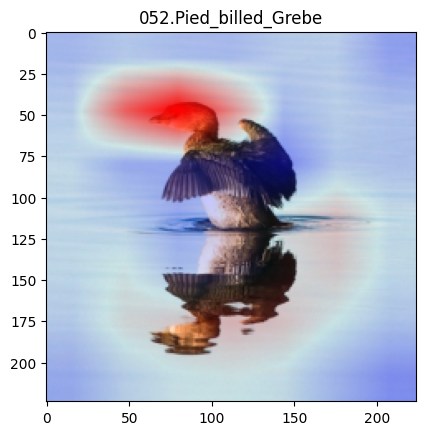

In [38]:
show_image(explain(image, contrast=None, target=51, map='both'), label)

In [39]:
img_orig1 = np.array(blur(image))
mask = orig1_red.sum(-1) < 3
img_orig1[mask] = np.array(image)[mask]

img_orig2 = np.array(blur(image))
mask = orig2_red.sum(-1) < 3
img_orig2[mask] = np.array(image)[mask]

img_weighted1 = np.array(blur(image))
mask = weighted1_red.sum(-1) < 3
img_weighted1[mask] = np.array(image)[mask]

img_weighted2 = np.array(blur(image))
mask = weighted2_red.sum(-1) < 3
img_weighted2[mask] = np.array(image)[mask]

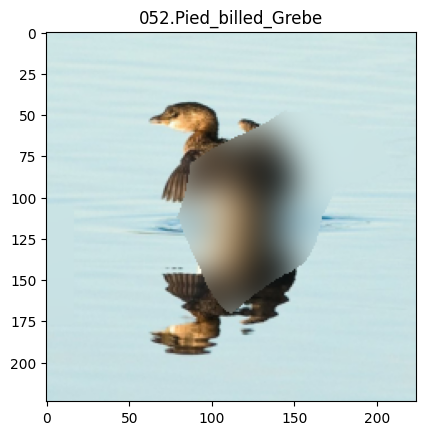

In [40]:
show_image(img_weighted1, label)

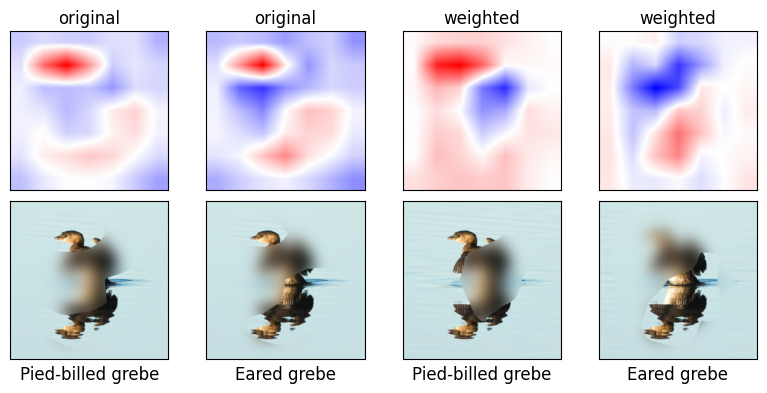

In [42]:
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["xtick.labelsize"] = 14.
plt.rcParams["ytick.labelsize"] = 14.
plt.rcParams["legend.fontsize"] = 12.

imgs = [[orig1, orig2, weighted1, weighted2],
        [img_orig1, img_orig2, img_weighted1, img_weighted2]]

fig, axs = plt.subplots(2, 4, figsize=(8, 4))
fig.subplots_adjust(wspace=0.05, hspace=0.01)
for i in range(2):
    for j in range(4):
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].imshow(imgs[i][j])

cols = ['original', 'original', 'weighted', 'weighted']
xs = ['Pied-billed grebe', 'Eared grebe', 'Pied-billed grebe', 'Eared grebe']

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, x in zip(axs[-1], xs):
    ax.set_xlabel(x, size='large')

fig.tight_layout()
plt.savefig('exp0_2.png', bbox_inches='tight');

In [49]:
image, label = cub200[115]

# image: p1 0.616, p2 0.206
# img_orig1: p1 0.986 p2 0.001
# img_orig2: p1 0.890 p2 0.002
# img_weigted1: p1 0.333 p2 0.009
# img_weigted2: p1 0.165 p2 0.143

with torch.set_grad_enabled(False):
    logits = model_ft(normalize(img_orig1)[np.newaxis, :].to(device))
    probs = nn.functional.softmax(logits)
    print(probs[0, 51], probs[0, 49])

tensor(0.1646, device='cuda:0') tensor(0.1432, device='cuda:0')


<ipython-input-49-86252013bb10>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = nn.functional.softmax(logits)


## Experiment 1

In [ ]:
image, label = cub200[115]

np.sum(explain(image, contrast=None, target=None, map='blue', method=linear_approx_contrast, background=WHITE).sum(-1) < 3)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


36673

In [ ]:
image, label = cub200[51]

def get_top2(image):
    with torch.set_grad_enabled(False):
        logits = model_ft(normalize(image)[np.newaxis, :])
        probs = nn.functional.softmax(logits)
        return probs.argsort(1, descending=True)[0, :2]

get_top2(image)

drive/MyDrive/CUB-200/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0088_796133.jpg


<ipython-input-24-49e3e2a7b803>:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = nn.functional.softmax(logits)


tensor([2, 1])

drive/MyDrive/CUB-200/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0088_796133.jpg


<ipython-input-24-49e3e2a7b803>:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = nn.functional.softmax(logits)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([224, 224])
torch.Size([224, 224])
drive/MyDrive/CUB-200/CUB_200_2011/images/002.Laysan_Albatross/Laysan_Albatross_0075_668.jpg
torch.Size([224, 224])
torch.Size([224, 224])
drive/MyDrive/CUB-200/CUB_200_2011/images/003.Sooty_Albatross/Sooty_Albatross_0010_796355.jpg
torch.Size([224, 224])
torch.Size([224, 224])
drive/MyDrive/CUB-200/CUB_200_2011/images/004.Groove_billed_Ani/Groove_Billed_Ani_0062_1767.jpg
torch.Size([224, 224])
torch.Size([224, 224])
drive/MyDrive/CUB-200/CUB_200_2011/images/006.Least_Auklet/Least_Auklet_0063_795134.jpg
torch.Size([224, 224])
torch.Size([224, 224])
drive/MyDrive/CUB-200/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0088_796133.jpg
torch.Size([200, 7, 7])
torch.Size([224, 224])
torch.Size([200, 7, 7])
torch.Size([224, 224])
drive/MyDrive/CUB-200/CUB_200_2011/images/002.Laysan_Albatross/Laysan_Albatross_0075_668.jpg
torch.Size([200, 7, 7])
torch.Size([224, 224])
torch.Size([200, 7, 7])
torch.Size([224, 224])
drive/MyDr

torch.Size([200, 7, 7])
torch.Size([224, 224])


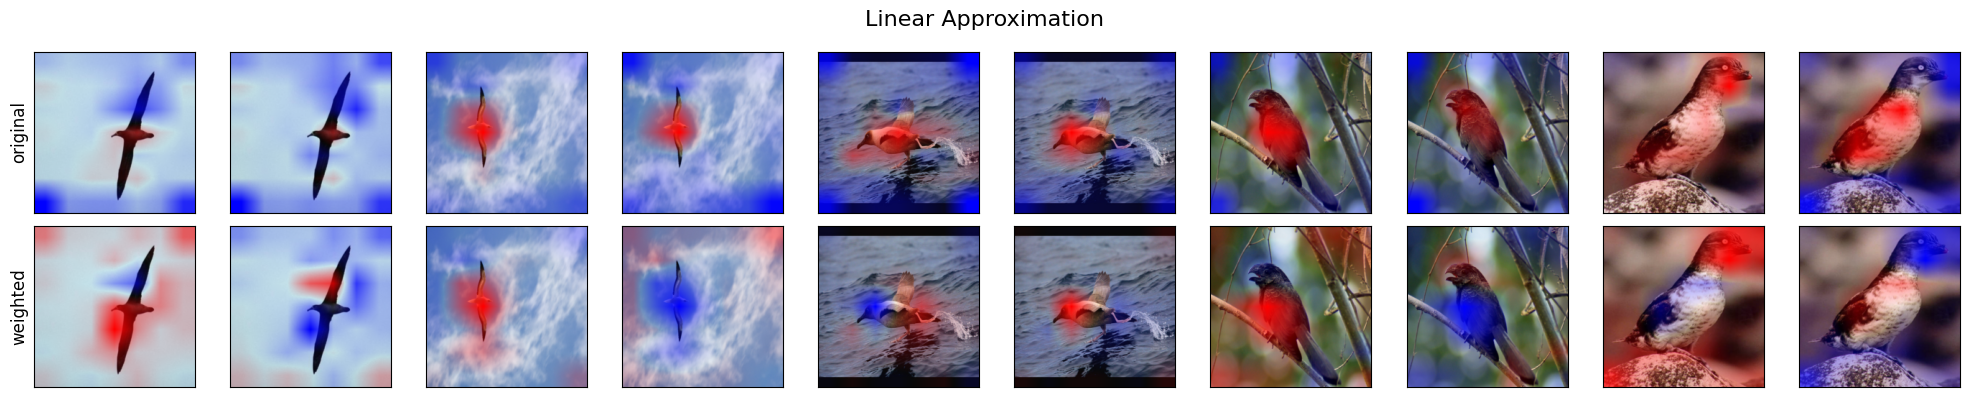

In [ ]:
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["xtick.labelsize"] = 14.
plt.rcParams["ytick.labelsize"] = 14.
plt.rcParams["legend.fontsize"] = 12.

fig, axs = plt.subplots(2, 10, figsize=(20, 4))
fig.subplots_adjust(wspace=0.05, hspace=0.05)

# imgs_gradcam = [[None] * 10, [None] * 10]
imgs_la = [[None] * 10, [None] * 10]

for i, contrast in enumerate([None, 'weighted']):
    for j, img_id in enumerate([51, 94, 153, 232, 322]):
        image, _ = cub200[img_id]
        for h, target in enumerate(get_top2(image)):
            axs[i][2*j+h].set_xticks([])
            axs[i][2*j+h].set_yticks([])
            imgs_la[i][2*j+h] = explain(image, contrast, target, map='both', method=linear_approx_contrast)

for i in range(2):
    for j in range(10):
        axs[i][j].imshow(imgs_la[i][j])

rows = ['original', 'weighted']

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, size='large')

fig.suptitle('Linear Approximation', fontsize=16)
fig.tight_layout()
plt.savefig('exp2_la.png', bbox_inches='tight');

## Experiment 2

In [ ]:
# OBAMA

In [ ]:
cub_test = Cub2011(cub_root, train=False, transform=resize2, download=False)
test_dataloader = torch.utils.data.DataLoader(cub_test, batch_size=1, shuffle=True, num_workers=2)

In [ ]:
# 0 - Blur, 1 - Zeros, 2 - Channel Mean
# 0 - Pos, 1 - Neg
# 0 - ori, 1 - wtd
# 0 - la, 1 - gc
# 0 - t1, 1 - t2
all_stats = []
all_p1, all_p2 = [], []
cnt = 0
for image, label in tqdm(test_dataloader):
    image = image.to(device)
    with torch.set_grad_enabled(False):
        logits = model_ft(normalize2(image)).detach().cpu()
    probs = nn.functional.softmax(logits)
    t1, t2 = probs.argsort(1, descending=True)[0, :2]

    if probs[0, t2] > 0.1:
        cnt += 1
        print(f'{cnt}/300')
        p1, p2 = probs[0, [t1, t2]]
        p1_total = p1 / (p1 + p2)
        p2_total = p2 / (p1 + p2)
        all_p1.append(p1_total)
        all_p2.append(p2_total)
        stats = np.zeros((3, 2, 2, 2, 2))
        for i1, baseline in enumerate([blur, zeros, chmean]):
            for i2, map in enumerate(['red', 'blue']):
                for i3, contrast in enumerate([None, 'weighted']):
                    for i4, method in enumerate([linear_approx_contrast, grad_cam_fn_contrast]):
                        for i5, target in enumerate([t1, t2]):
                            with torch.set_grad_enabled(True):
                                mask = explain(image=image, contrast=contrast, target=target, map=map, method=method, background=WHITE).sum(-1) < 3
                            image_pil = transforms.ToPILImage()(image[0])
                            blurred_img = baseline(image_pil)
                            blurred_img[mask] = np.array(image_pil)[mask]
                            with torch.set_grad_enabled(False):
                                logits_ = model_ft(normalize(blurred_img)[np.newaxis, :].to(device)).detach().cpu()
                            probs_ = nn.functional.softmax(logits_)
                            p1_, p2_ = probs_[0, [t1, t2]]
                            stats[i1][i2][i3][i4][i5] = (p2_ if i5 else p1_) / (p1_ + p2_)
        all_stats.append(stats)
    if cnt >= 300:
        break

  0%|          | 0/5794 [00:00<?, ?it/s]<ipython-input-32-f157d3f2dbac>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = nn.functional.softmax(logits)
  0%|          | 6/5794 [00:02<42:41,  2.26it/s]

1/300


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
<ipython-input-32-f157d3f2dbac>:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs_ = nn.functional.softmax(logits_)
  0%|          | 7/5794 [00:32<15:28:46,  9.63s/it]

2/300


  0%|          | 8/5794 [01:00<24:28:52, 15.23s/it]

3/300


  0%|          | 9/5794 [01:28<30:41:26, 19.10s/it]

4/300


  0%|          | 11/5794 [01:55<26:46:00, 16.66s/it]

5/300


  0%|          | 12/5794 [02:23<31:10:28, 19.41s/it]

6/300


  0%|          | 13/5794 [02:51<34:38:11, 21.57s/it]

7/300


  0%|          | 14/5794 [03:19<37:21:16, 23.27s/it]

8/300


  0%|          | 15/5794 [03:46<39:19:47, 24.50s/it]

9/300


  0%|          | 16/5794 [04:14<40:50:21, 25.45s/it]

10/300


  0%|          | 17/5794 [04:42<41:55:37, 26.13s/it]

11/300


  0%|          | 19/5794 [05:10<33:00:59, 20.58s/it]

12/300


  0%|          | 20/5794 [05:38<36:06:48, 22.52s/it]

13/300


  0%|          | 21/5794 [06:06<38:17:10, 23.88s/it]

14/300


  0%|          | 22/5794 [06:34<39:56:49, 24.92s/it]

15/300


  0%|          | 26/5794 [07:02<22:42:22, 14.17s/it]

16/300


  0%|          | 28/5794 [07:30<22:36:15, 14.11s/it]

17/300


  1%|          | 30/5794 [07:58<22:28:10, 14.03s/it]

18/300


  1%|          | 31/5794 [08:26<26:17:35, 16.42s/it]

19/300


  1%|          | 33/5794 [08:53<24:54:38, 15.57s/it]

20/300


  1%|          | 34/5794 [09:21<28:37:59, 17.90s/it]

21/300


  1%|          | 38/5794 [09:49<19:24:45, 12.14s/it]

22/300


  1%|          | 40/5794 [10:17<20:13:33, 12.65s/it]

23/300


  1%|          | 43/5794 [10:44<18:13:02, 11.40s/it]

24/300


  1%|          | 45/5794 [11:12<19:17:31, 12.08s/it]

25/300


  1%|          | 46/5794 [11:40<23:13:24, 14.54s/it]

26/300


  1%|          | 48/5794 [12:08<22:52:35, 14.33s/it]

27/300


  1%|          | 49/5794 [12:36<26:44:23, 16.76s/it]

28/300


  1%|          | 50/5794 [13:04<30:22:51, 19.04s/it]

29/300


  1%|          | 51/5794 [13:31<33:31:02, 21.01s/it]

30/300


  1%|          | 52/5794 [13:59<36:06:49, 22.64s/it]

31/300


  1%|          | 53/5794 [14:27<38:13:41, 23.97s/it]

32/300


  1%|          | 54/5794 [14:55<39:50:49, 24.99s/it]

33/300


  1%|          | 56/5794 [15:23<32:17:05, 20.26s/it]

34/300


  1%|          | 57/5794 [15:51<35:12:39, 22.10s/it]

35/300


  1%|          | 58/5794 [16:19<37:28:10, 23.52s/it]

36/300


  1%|          | 59/5794 [16:46<39:14:04, 24.63s/it]

37/300


  1%|          | 62/5794 [17:14<26:13:15, 16.47s/it]

38/300


  1%|          | 67/5794 [17:43<16:41:12, 10.49s/it]

39/300


  1%|          | 68/5794 [18:11<20:26:27, 12.85s/it]

40/300


  1%|          | 69/5794 [18:38<24:19:21, 15.29s/it]

41/300


  1%|          | 70/5794 [19:06<28:10:10, 17.72s/it]

42/300


  1%|▏         | 73/5794 [19:34<22:08:54, 13.94s/it]

43/300


  1%|▏         | 75/5794 [20:02<22:07:56, 13.93s/it]

44/300


  1%|▏         | 77/5794 [20:30<22:07:31, 13.93s/it]

45/300


  1%|▏         | 80/5794 [20:58<19:13:04, 12.11s/it]

46/300


  1%|▏         | 81/5794 [21:26<23:08:53, 14.59s/it]

47/300


  1%|▏         | 83/5794 [21:54<22:48:47, 14.38s/it]

48/300


  1%|▏         | 85/5794 [22:21<22:31:36, 14.21s/it]

49/300


  2%|▏         | 87/5794 [22:49<22:22:08, 14.11s/it]

50/300


  2%|▏         | 90/5794 [23:17<19:19:09, 12.19s/it]

51/300


  2%|▏         | 91/5794 [23:45<23:14:55, 14.68s/it]

52/300


  2%|▏         | 92/5794 [24:12<27:02:44, 17.08s/it]

53/300


  2%|▏         | 93/5794 [24:40<30:31:51, 19.28s/it]

54/300


  2%|▏         | 95/5794 [25:08<27:21:47, 17.29s/it]

55/300


  2%|▏         | 96/5794 [25:35<30:48:05, 19.46s/it]

56/300


  2%|▏         | 97/5794 [26:03<33:49:44, 21.38s/it]

57/300


  2%|▏         | 101/5794 [26:31<20:49:44, 13.17s/it]

58/300


  2%|▏         | 102/5794 [26:59<24:42:40, 15.63s/it]

59/300


  2%|▏         | 103/5794 [27:26<28:23:48, 17.96s/it]

60/300


  2%|▏         | 104/5794 [27:54<31:40:22, 20.04s/it]

61/300


  2%|▏         | 109/5794 [28:22<17:51:43, 11.31s/it]

62/300


  2%|▏         | 110/5794 [28:50<21:40:11, 13.72s/it]

63/300


  2%|▏         | 111/5794 [29:18<25:30:32, 16.16s/it]

64/300


  2%|▏         | 112/5794 [29:45<29:11:13, 18.49s/it]

65/300


  2%|▏         | 113/5794 [30:13<32:23:12, 20.52s/it]

66/300


  2%|▏         | 114/5794 [30:41<35:07:10, 22.26s/it]

67/300


  2%|▏         | 117/5794 [31:09<24:40:58, 15.65s/it]

68/300


  2%|▏         | 118/5794 [31:36<28:24:04, 18.01s/it]

69/300


  2%|▏         | 119/5794 [32:04<31:45:43, 20.15s/it]

70/300


  2%|▏         | 120/5794 [32:32<34:36:48, 21.96s/it]

71/300


  2%|▏         | 121/5794 [33:00<36:56:38, 23.44s/it]

72/300


  2%|▏         | 122/5794 [33:28<38:48:40, 24.63s/it]

73/300


  2%|▏         | 123/5794 [33:55<40:08:15, 25.48s/it]

74/300


  2%|▏         | 124/5794 [34:23<41:06:29, 26.10s/it]

75/300


  2%|▏         | 125/5794 [34:51<41:50:48, 26.57s/it]

76/300


  2%|▏         | 126/5794 [35:18<42:18:27, 26.87s/it]

77/300


  2%|▏         | 127/5794 [35:46<42:36:08, 27.06s/it]

78/300


  2%|▏         | 128/5794 [36:13<42:48:25, 27.20s/it]

79/300


  2%|▏         | 133/5794 [36:42<19:47:15, 12.58s/it]

80/300


  2%|▏         | 134/5794 [37:09<23:36:01, 15.01s/it]

81/300


  2%|▏         | 137/5794 [37:37<19:51:54, 12.64s/it]

82/300


  2%|▏         | 140/5794 [38:05<17:53:06, 11.39s/it]

83/300


  2%|▏         | 141/5794 [38:32<21:42:12, 13.82s/it]

84/300


  2%|▏         | 142/5794 [39:00<25:31:03, 16.25s/it]

85/300


  2%|▏         | 143/5794 [39:28<29:05:44, 18.54s/it]

86/300


  2%|▏         | 144/5794 [39:55<32:14:05, 20.54s/it]

87/300


  3%|▎         | 147/5794 [40:23<23:30:56, 14.99s/it]

88/300


  3%|▎         | 148/5794 [40:50<27:12:38, 17.35s/it]

89/300


  3%|▎         | 150/5794 [41:18<25:12:17, 16.08s/it]

90/300


  3%|▎         | 156/5794 [41:46<11:59:04,  7.65s/it]

91/300


  3%|▎         | 157/5794 [42:13<16:27:21, 10.51s/it]

92/300


  3%|▎         | 158/5794 [42:41<20:58:21, 13.40s/it]

93/300


  3%|▎         | 163/5794 [43:09<14:17:06,  9.13s/it]

94/300


  3%|▎         | 165/5794 [43:37<16:02:37, 10.26s/it]

95/300


  3%|▎         | 166/5794 [44:04<19:59:00, 12.78s/it]

96/300


  3%|▎         | 167/5794 [44:32<24:05:15, 15.41s/it]

97/300


  3%|▎         | 169/5794 [45:00<23:17:40, 14.91s/it]

98/300


  3%|▎         | 170/5794 [45:28<27:12:32, 17.42s/it]

99/300


  3%|▎         | 173/5794 [45:56<21:28:15, 13.75s/it]

100/300


  3%|▎         | 175/5794 [46:24<21:30:03, 13.78s/it]

101/300


  3%|▎         | 177/5794 [46:51<21:31:26, 13.79s/it]

102/300


  3%|▎         | 178/5794 [47:19<25:20:19, 16.24s/it]

103/300


  3%|▎         | 180/5794 [47:47<24:07:38, 15.47s/it]

104/300


  3%|▎         | 181/5794 [48:15<27:49:11, 17.84s/it]

105/300


  3%|▎         | 184/5794 [48:42<21:41:29, 13.92s/it]

106/300


  3%|▎         | 185/5794 [49:10<25:29:44, 16.36s/it]

107/300


  3%|▎         | 186/5794 [49:37<28:59:02, 18.61s/it]

108/300


  3%|▎         | 187/5794 [50:05<32:06:27, 20.61s/it]

109/300


  3%|▎         | 190/5794 [50:32<23:22:08, 15.01s/it]

110/300


  3%|▎         | 191/5794 [51:00<27:04:50, 17.40s/it]

111/300


  3%|▎         | 192/5794 [51:28<30:26:36, 19.56s/it]

112/300


  3%|▎         | 195/5794 [51:55<22:44:02, 14.62s/it]

113/300


  3%|▎         | 196/5794 [52:23<26:32:10, 17.07s/it]

114/300


  3%|▎         | 197/5794 [52:51<29:56:07, 19.25s/it]

115/300


  3%|▎         | 198/5794 [53:18<33:00:23, 21.23s/it]

116/300


  3%|▎         | 201/5794 [53:47<23:54:51, 15.39s/it]

117/300


  3%|▎         | 202/5794 [54:15<27:34:11, 17.75s/it]

118/300


  4%|▎         | 203/5794 [54:42<30:48:17, 19.84s/it]

119/300


  4%|▎         | 204/5794 [55:10<33:40:12, 21.68s/it]

120/300


  4%|▎         | 205/5794 [55:38<36:01:24, 23.20s/it]

121/300


  4%|▎         | 206/5794 [56:05<37:45:55, 24.33s/it]

122/300


  4%|▎         | 207/5794 [56:32<39:01:12, 25.14s/it]

123/300


  4%|▎         | 208/5794 [57:00<40:06:03, 25.84s/it]

124/300


  4%|▎         | 211/5794 [57:28<26:00:08, 16.77s/it]

125/300


  4%|▎         | 212/5794 [57:55<29:26:05, 18.98s/it]

126/300


  4%|▎         | 214/5794 [58:23<26:27:52, 17.07s/it]

127/300


  4%|▍         | 219/5794 [58:51<16:23:10, 10.58s/it]

128/300


  4%|▍         | 220/5794 [59:19<20:04:13, 12.96s/it]

129/300


  4%|▍         | 221/5794 [59:47<23:54:32, 15.44s/it]

130/300


  4%|▍         | 222/5794 [1:00:14<27:35:24, 17.83s/it]

131/300


  4%|▍         | 224/5794 [1:00:42<25:25:09, 16.43s/it]

132/300


  4%|▍         | 225/5794 [1:01:10<28:57:54, 18.72s/it]

133/300


  4%|▍         | 229/5794 [1:01:38<19:12:06, 12.42s/it]

134/300


  4%|▍         | 231/5794 [1:02:05<19:45:53, 12.79s/it]

135/300


  4%|▍         | 234/5794 [1:02:33<17:43:04, 11.47s/it]

136/300


  4%|▍         | 235/5794 [1:03:01<21:35:46, 13.99s/it]

137/300


  4%|▍         | 238/5794 [1:03:29<18:42:56, 12.13s/it]

138/300


  4%|▍         | 239/5794 [1:03:57<22:30:17, 14.58s/it]

139/300


  4%|▍         | 240/5794 [1:04:24<26:08:36, 16.95s/it]

140/300


  4%|▍         | 242/5794 [1:04:52<24:27:20, 15.86s/it]

141/300


  4%|▍         | 243/5794 [1:05:19<28:01:41, 18.18s/it]

142/300


  4%|▍         | 246/5794 [1:05:47<21:42:47, 14.09s/it]

143/300


  4%|▍         | 247/5794 [1:06:15<25:26:43, 16.51s/it]

144/300


  4%|▍         | 248/5794 [1:06:42<28:53:42, 18.76s/it]

145/300


  4%|▍         | 251/5794 [1:07:10<22:01:46, 14.31s/it]

146/300


  4%|▍         | 252/5794 [1:07:38<25:46:13, 16.74s/it]

147/300


  4%|▍         | 254/5794 [1:08:05<24:14:10, 15.75s/it]

148/300


  4%|▍         | 255/5794 [1:08:33<27:49:26, 18.08s/it]

149/300


  4%|▍         | 258/5794 [1:09:01<21:34:46, 14.03s/it]

150/300


  4%|▍         | 259/5794 [1:09:28<25:18:42, 16.46s/it]

151/300


  4%|▍         | 260/5794 [1:09:56<28:44:45, 18.70s/it]

152/300


  5%|▍         | 262/5794 [1:10:23<25:57:30, 16.89s/it]

153/300


  5%|▍         | 263/5794 [1:10:51<29:20:22, 19.10s/it]

154/300


  5%|▍         | 264/5794 [1:11:18<32:16:27, 21.01s/it]

155/300


  5%|▍         | 265/5794 [1:11:46<34:49:32, 22.68s/it]

156/300


  5%|▍         | 267/5794 [1:12:13<29:08:33, 18.98s/it]

157/300


  5%|▍         | 268/5794 [1:12:41<32:11:38, 20.97s/it]

158/300


  5%|▍         | 274/5794 [1:13:10<12:47:29,  8.34s/it]

159/300


  5%|▍         | 275/5794 [1:13:38<17:21:29, 11.32s/it]

160/300


  5%|▍         | 278/5794 [1:14:05<16:03:41, 10.48s/it]

161/300


  5%|▍         | 280/5794 [1:14:33<17:29:05, 11.42s/it]

162/300


  5%|▍         | 281/5794 [1:15:01<21:33:23, 14.08s/it]

163/300


  5%|▍         | 283/5794 [1:15:28<21:23:57, 13.98s/it]

164/300


  5%|▍         | 284/5794 [1:15:56<25:17:36, 16.53s/it]

165/300


  5%|▍         | 285/5794 [1:16:23<28:49:36, 18.84s/it]

166/300


  5%|▍         | 286/5794 [1:16:51<31:53:11, 20.84s/it]

167/300


  5%|▍         | 287/5794 [1:17:19<34:24:45, 22.50s/it]

168/300


  5%|▌         | 290/5794 [1:17:46<23:55:35, 15.65s/it]

169/300


  5%|▌         | 294/5794 [1:18:14<17:16:19, 11.31s/it]

170/300


  5%|▌         | 295/5794 [1:18:41<20:58:57, 13.74s/it]

171/300


  5%|▌         | 296/5794 [1:19:09<24:45:22, 16.21s/it]

172/300


  5%|▌         | 298/5794 [1:19:36<23:31:13, 15.41s/it]

173/300


  5%|▌         | 300/5794 [1:20:04<22:45:28, 14.91s/it]

174/300


  5%|▌         | 301/5794 [1:20:32<26:31:40, 17.39s/it]

175/300


  5%|▌         | 305/5794 [1:21:00<18:19:39, 12.02s/it]

176/300


  5%|▌         | 306/5794 [1:21:28<22:02:51, 14.46s/it]

177/300


  5%|▌         | 308/5794 [1:21:56<21:42:34, 14.25s/it]

178/300


  5%|▌         | 309/5794 [1:22:23<25:18:56, 16.62s/it]

179/300


  5%|▌         | 310/5794 [1:22:51<28:45:09, 18.87s/it]

180/300


  5%|▌         | 312/5794 [1:23:18<25:51:03, 16.98s/it]

181/300


  5%|▌         | 313/5794 [1:23:46<29:11:25, 19.17s/it]

182/300


  5%|▌         | 314/5794 [1:24:13<32:03:10, 21.06s/it]

183/300


  5%|▌         | 315/5794 [1:24:41<34:31:07, 22.68s/it]

184/300


  5%|▌         | 316/5794 [1:25:08<36:29:41, 23.98s/it]

185/300


  5%|▌         | 318/5794 [1:25:36<29:54:36, 19.66s/it]

186/300


  6%|▌         | 319/5794 [1:26:04<32:49:48, 21.59s/it]

187/300


  6%|▌         | 320/5794 [1:26:32<35:15:02, 23.18s/it]

188/300


  6%|▌         | 321/5794 [1:27:00<37:07:11, 24.42s/it]

189/300


  6%|▌         | 323/5794 [1:27:27<30:09:50, 19.85s/it]

190/300


  6%|▌         | 324/5794 [1:27:55<32:57:05, 21.69s/it]

191/300


  6%|▌         | 325/5794 [1:28:23<35:12:20, 23.17s/it]

192/300


  6%|▌         | 326/5794 [1:28:50<36:55:14, 24.31s/it]

193/300


  6%|▌         | 327/5794 [1:29:18<38:14:07, 25.18s/it]

194/300


  6%|▌         | 329/5794 [1:29:45<30:43:14, 20.24s/it]

195/300


  6%|▌         | 330/5794 [1:30:13<33:22:17, 21.99s/it]

196/300


  6%|▌         | 331/5794 [1:30:40<35:26:37, 23.36s/it]

197/300


  6%|▌         | 334/5794 [1:31:08<24:14:01, 15.98s/it]

198/300


  6%|▌         | 336/5794 [1:31:35<23:07:01, 15.25s/it]

199/300


  6%|▌         | 341/5794 [1:32:04<15:14:08, 10.06s/it]

200/300


  6%|▌         | 343/5794 [1:32:32<16:35:19, 10.96s/it]

201/300


  6%|▌         | 345/5794 [1:32:59<17:39:09, 11.66s/it]

202/300


  6%|▌         | 349/5794 [1:33:27<14:37:21,  9.67s/it]

203/300


  6%|▌         | 350/5794 [1:33:54<18:09:06, 12.00s/it]

204/300


  6%|▌         | 351/5794 [1:34:22<21:49:39, 14.44s/it]

205/300


  6%|▌         | 354/5794 [1:34:50<18:39:25, 12.35s/it]

206/300


  6%|▌         | 356/5794 [1:35:17<19:14:33, 12.74s/it]

207/300


  6%|▌         | 357/5794 [1:35:44<22:53:55, 15.16s/it]

208/300


  6%|▌         | 360/5794 [1:36:12<19:08:24, 12.68s/it]

209/300


  6%|▋         | 364/5794 [1:36:39<15:15:28, 10.12s/it]

210/300


  6%|▋         | 366/5794 [1:37:07<16:34:19, 10.99s/it]

211/300


  6%|▋         | 368/5794 [1:37:34<17:37:22, 11.69s/it]

212/300


  6%|▋         | 370/5794 [1:38:02<18:30:20, 12.28s/it]

213/300


  6%|▋         | 373/5794 [1:38:30<16:50:06, 11.18s/it]

214/300


  7%|▋         | 377/5794 [1:38:58<14:11:55,  9.44s/it]

215/300


  7%|▋         | 378/5794 [1:39:25<17:42:42, 11.77s/it]

216/300


  7%|▋         | 380/5794 [1:39:53<18:32:13, 12.33s/it]

217/300


  7%|▋         | 382/5794 [1:40:21<19:09:13, 12.74s/it]

218/300


  7%|▋         | 384/5794 [1:40:48<19:36:05, 13.04s/it]

219/300


  7%|▋         | 385/5794 [1:41:16<23:17:53, 15.51s/it]

220/300


  7%|▋         | 386/5794 [1:41:44<26:47:29, 17.83s/it]

221/300


  7%|▋         | 387/5794 [1:42:11<29:57:57, 19.95s/it]

222/300


  7%|▋         | 388/5794 [1:42:39<32:34:18, 21.69s/it]

223/300


  7%|▋         | 389/5794 [1:43:06<34:48:33, 23.18s/it]

224/300


  7%|▋         | 390/5794 [1:43:34<36:33:55, 24.36s/it]

225/300


  7%|▋         | 392/5794 [1:44:01<29:43:59, 19.81s/it]

226/300


  7%|▋         | 393/5794 [1:44:29<32:25:51, 21.62s/it]

227/300


  7%|▋         | 397/5794 [1:44:57<19:47:06, 13.20s/it]

228/300


  7%|▋         | 398/5794 [1:45:24<23:28:35, 15.66s/it]

229/300


  7%|▋         | 399/5794 [1:45:52<26:58:33, 18.00s/it]

230/300


  7%|▋         | 403/5794 [1:46:20<18:13:45, 12.17s/it]

231/300


  7%|▋         | 405/5794 [1:46:48<18:55:16, 12.64s/it]

232/300


  7%|▋         | 407/5794 [1:47:15<19:25:40, 12.98s/it]

233/300


  7%|▋         | 408/5794 [1:47:43<23:06:25, 15.44s/it]

234/300


  7%|▋         | 409/5794 [1:48:10<26:33:24, 17.75s/it]

235/300


  7%|▋         | 411/5794 [1:48:38<24:23:59, 16.32s/it]

236/300


  7%|▋         | 412/5794 [1:49:05<27:46:21, 18.58s/it]

237/300


  7%|▋         | 413/5794 [1:49:33<30:49:42, 20.62s/it]

238/300


  7%|▋         | 415/5794 [1:50:01<26:48:20, 17.94s/it]

239/300


  7%|▋         | 416/5794 [1:50:28<30:02:10, 20.11s/it]

240/300


  7%|▋         | 417/5794 [1:50:56<32:44:53, 21.93s/it]

241/300


  7%|▋         | 418/5794 [1:51:24<34:55:49, 23.39s/it]

242/300


  7%|▋         | 419/5794 [1:51:52<36:40:12, 24.56s/it]

243/300


  7%|▋         | 421/5794 [1:52:19<29:47:53, 19.97s/it]

244/300


  7%|▋         | 422/5794 [1:52:47<32:29:21, 21.77s/it]

245/300


  7%|▋         | 423/5794 [1:53:15<34:39:34, 23.23s/it]

246/300


  7%|▋         | 425/5794 [1:53:42<28:45:50, 19.29s/it]

247/300


  7%|▋         | 426/5794 [1:54:10<31:37:38, 21.21s/it]

248/300


  7%|▋         | 427/5794 [1:54:37<33:52:27, 22.72s/it]

249/300


  7%|▋         | 429/5794 [1:55:05<28:21:49, 19.03s/it]

250/300


  7%|▋         | 431/5794 [1:55:33<25:36:08, 17.19s/it]

251/300


  8%|▊         | 435/5794 [1:56:00<17:39:48, 11.87s/it]

252/300


  8%|▊         | 438/5794 [1:56:28<16:16:58, 10.94s/it]

253/300


  8%|▊         | 439/5794 [1:56:56<19:52:17, 13.36s/it]

254/300


  8%|▊         | 440/5794 [1:57:23<23:29:52, 15.80s/it]

255/300


  8%|▊         | 441/5794 [1:57:51<26:57:28, 18.13s/it]

256/300


  8%|▊         | 442/5794 [1:58:19<29:59:06, 20.17s/it]

257/300


  8%|▊         | 443/5794 [1:58:46<32:42:37, 22.01s/it]

258/300


  8%|▊         | 445/5794 [1:59:14<27:49:35, 18.73s/it]

259/300


  8%|▊         | 447/5794 [1:59:42<25:09:02, 16.93s/it]

260/300


  8%|▊         | 450/5794 [2:00:10<20:05:45, 13.54s/it]

261/300


  8%|▊         | 451/5794 [2:00:37<23:42:17, 15.97s/it]

262/300


  8%|▊         | 452/5794 [2:01:05<27:08:19, 18.29s/it]

263/300


  8%|▊         | 454/5794 [2:01:32<24:38:59, 16.62s/it]

264/300


  8%|▊         | 456/5794 [2:02:00<23:10:28, 15.63s/it]

265/300


  8%|▊         | 457/5794 [2:02:27<26:41:35, 18.01s/it]

266/300


  8%|▊         | 458/5794 [2:02:55<29:52:38, 20.16s/it]

267/300


  8%|▊         | 459/5794 [2:03:23<32:33:23, 21.97s/it]

268/300


  8%|▊         | 460/5794 [2:03:51<34:57:12, 23.59s/it]

269/300


  8%|▊         | 462/5794 [2:04:19<28:56:28, 19.54s/it]

270/300


  8%|▊         | 464/5794 [2:04:47<25:43:31, 17.38s/it]

271/300


  8%|▊         | 465/5794 [2:05:15<29:00:24, 19.60s/it]

272/300


  8%|▊         | 469/5794 [2:05:43<18:48:34, 12.72s/it]

273/300


  8%|▊         | 470/5794 [2:06:10<22:23:57, 15.15s/it]

274/300


  8%|▊         | 471/5794 [2:06:38<25:55:35, 17.53s/it]

275/300


  8%|▊         | 472/5794 [2:07:06<29:10:45, 19.74s/it]

276/300


  8%|▊         | 475/5794 [2:07:33<21:43:05, 14.70s/it]

277/300


  8%|▊         | 476/5794 [2:08:01<25:13:48, 17.08s/it]

278/300


  8%|▊         | 478/5794 [2:08:28<23:29:26, 15.91s/it]

279/300


  8%|▊         | 479/5794 [2:08:56<26:49:34, 18.17s/it]

280/300


  8%|▊         | 481/5794 [2:09:24<24:32:00, 16.62s/it]

281/300


  8%|▊         | 482/5794 [2:09:51<27:53:04, 18.90s/it]

282/300


  8%|▊         | 483/5794 [2:10:19<30:56:12, 20.97s/it]

283/300


  8%|▊         | 484/5794 [2:10:47<33:26:18, 22.67s/it]

284/300


  8%|▊         | 487/5794 [2:11:15<23:18:15, 15.81s/it]

285/300


  8%|▊         | 489/5794 [2:11:43<22:20:42, 15.16s/it]

286/300


  9%|▊         | 493/5794 [2:12:11<16:36:52, 11.28s/it]

287/300


  9%|▊         | 495/5794 [2:12:39<17:35:37, 11.95s/it]

288/300


  9%|▊         | 498/5794 [2:13:07<16:09:15, 10.98s/it]

289/300


  9%|▊         | 500/5794 [2:13:34<17:12:06, 11.70s/it]

290/300


  9%|▊         | 502/5794 [2:14:02<17:58:51, 12.23s/it]

291/300


  9%|▊         | 503/5794 [2:14:29<21:30:50, 14.64s/it]

292/300


  9%|▊         | 504/5794 [2:14:57<25:05:07, 17.07s/it]

293/300


  9%|▊         | 506/5794 [2:15:25<23:29:21, 15.99s/it]

294/300


  9%|▉         | 508/5794 [2:15:53<22:27:44, 15.30s/it]

295/300


  9%|▉         | 511/5794 [2:16:20<18:45:54, 12.79s/it]

296/300


  9%|▉         | 512/5794 [2:16:48<22:23:56, 15.27s/it]

297/300


  9%|▉         | 515/5794 [2:17:16<18:46:51, 12.81s/it]

298/300


  9%|▉         | 517/5794 [2:17:44<19:15:11, 13.13s/it]

299/300


  9%|▉         | 519/5794 [2:18:12<19:33:35, 13.35s/it]

300/300


  9%|▉         | 519/5794 [2:18:40<23:29:23, 16.03s/it]


In [ ]:
a = np.stack(all_stats)
print(a.shape)
mean, std = a.mean(0), a.std(0)

(300, 3, 2, 2, 2, 2)


In [ ]:
mean.shape

(3, 2, 2, 2, 2)

In [ ]:
p1_total / cnt, p2_total / cnt

(tensor(0.6957), tensor(0.3043))

In [ ]:
result = np.zeros((4, 12))

for i1 in range(3):
    for i2 in range(2):
        for i3 in range(2):
            for i4 in range(2):
                for i5 in range(2):
                    result[2 * i4 + i5][4 * i1 + 2 * i2 + i3] = 1.96 * std[i1][i2][i3][i4][i5] / np.sqrt(300)

print(*result.tolist(), sep='\n')

[0.041285678538092584, 0.03225877132513171, 0.04321726078293316, 0.039507944137933654, 0.043225709619408234, 0.03774685278114825, 0.044656088516809536, 0.0438360136427552, 0.040385006353873903, 0.03219929881188165, 0.04180285337180464, 0.03932756457202956]
[0.04321047639145836, 0.03833383631652266, 0.04187169670902068, 0.032403730328905624, 0.043662384765626734, 0.04446030061449464, 0.044342424747745315, 0.03963403157892468, 0.04300048920474085, 0.039466075469514694, 0.04092593615126915, 0.03263232436710264]
[0.04040639278280233, 0.029392521992429168, 0.04388892420852774, 0.03969676638252906, 0.04297591543318759, 0.038044903649950855, 0.04267974903260229, 0.04324754011410863, 0.03962403830848207, 0.029520734186507316, 0.04198823847009815, 0.0402353688048004]
[0.04388448881896405, 0.03690747136294083, 0.04125632222287434, 0.03418768328631005, 0.04425540694454505, 0.043553617608219165, 0.042199221722914154, 0.04013240887908398, 0.04230370041264461, 0.03896114603333286, 0.0406550187477784

## Experiment 3


In [ ]:
image, label = cub200[1624]

with torch.set_grad_enabled(False):
    logits = model_ft(normalize(image)[np.newaxis, :])
    probs = nn.functional.softmax(logits)
    top3 = probs.argsort(1, descending=True)[0, :3]

for idx in top3:
    print(class_names[idx], probs[0, idx])

drive/MyDrive/CUB-200/CUB_200_2011/images/029.American_Crow/American_Crow_0127_25412.jpg
026.Bronzed_Cowbird tensor(0.3706)
029.American_Crow tensor(0.2213)
108.White_necked_Raven tensor(0.1948)


<ipython-input-23-e9f5bb45adc7>:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = nn.functional.softmax(logits)


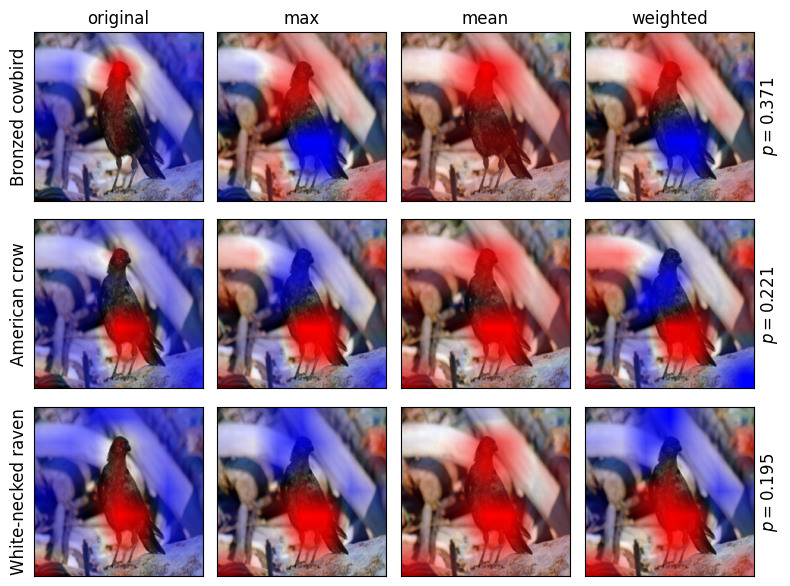

In [ ]:
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["xtick.labelsize"] = 14.
plt.rcParams["ytick.labelsize"] = 14.
plt.rcParams["legend.fontsize"] = 12.

fig, axs = plt.subplots(3, 4, figsize=(8, 6))
fig.subplots_adjust(wspace=0.05, hspace=0.05)
for i, target in enumerate(top3):
    for j, contrast in enumerate([None, 'max', 'mean', 'weighted']):
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].imshow(explain(image, contrast, target, map='both'))

cols = ['original', 'max', 'mean', 'weighted']

# rows = ['Shiny cowbird', 'Fish crow', 'American crow']
# probs = [0.346, 0.263, 0.199]

# rows = ['Brown creeper', 'Rock wren', 'Nighthawk']
# probs = [0.819, 0.067, 0.047]

rows = ['Bronzed cowbird', 'American crow', 'White-necked raven']
probs = [0.371, 0.221, 0.195]

# rows = ['Mockingbird', 'Tennessee warbler', 'Rock wren']
# probs = [0.217, 0.178, 0.087]

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, size='large')

for ax, prob in zip(axs[:,-1], probs):
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(f'$p = {prob}$', size='large')


fig.tight_layout()
plt.savefig('exp3_img3.png', bbox_inches='tight');